# Importing Libraries

In [ ]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

# Input and Output State

In [ ]:
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel
from typing import Optional

class ChatMessages(BaseModel):
    question: str
    answer: Optional[str] = ""
    llm_calls: Optional[int] = 0

In [ ]:
def call_model(state: ChatMessages):
    question = state.question
    llm_calls = state.llm_calls
    state.llm_calls = llm_calls + 1
    print(f"llm_calls: {state.llm_calls}")

    response = llm.invoke(question)
    state.answer = response.content
    return state

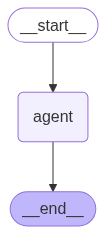

In [ ]:
workflow = StateGraph(ChatMessages)

workflow.add_node("agent", call_model)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", END)

graph = workflow.compile()
graph

In [ ]:
res = graph.invoke(input={"question": "What is responsible AI"})
res

llm_calls: 1


{'question': 'What is responsible AI',
 'answer': '<think>\n\n</think>\n\nResponsible AI refers to the development, deployment, and use of artificial intelligence (AI) systems in ways that are ethical, transparent, fair, and accountable. It involves ensuring that AI technologies are designed and implemented to align with human values, respect privacy and security, and promote societal well-being. Key principles of responsible AI include:\n\n1. **Ethical Considerations**: Ensuring AI systems are aligned with ethical standards, such as respect for human rights, non-discrimination, and fairness.\n\n2. **Transparency and Explainability**: Making AI decisions understandable to users and stakeholders, so that outcomes can be reviewed and trusted.\n\n3. **Accountability**: Holding developers, deployers, and users of AI systems accountable for their impact on society and individuals.\n\n4. **Privacy and Security**: Protecting personal data and ensuring AI systems are secure from misuse or expl

In [ ]:
print(res['answer'])

<think>

</think>

Responsible AI refers to the development, deployment, and use of artificial intelligence (AI) systems in ways that are ethical, transparent, fair, and accountable. It involves ensuring that AI technologies are designed and implemented to align with human values, respect privacy and security, and promote societal well-being. Key principles of responsible AI include:

1. **Ethical Considerations**: Ensuring AI systems are aligned with ethical standards, such as respect for human rights, non-discrimination, and fairness.

2. **Transparency and Explainability**: Making AI decisions understandable to users and stakeholders, so that outcomes can be reviewed and trusted.

3. **Accountability**: Holding developers, deployers, and users of AI systems accountable for their impact on society and individuals.

4. **Privacy and Security**: Protecting personal data and ensuring AI systems are secure from misuse or exploitation.

5. **Human Oversight and Control**: Ensuring that hu

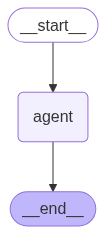

In [ ]:
from pydantic import BaseModel, Field

class InputState(BaseModel):
    question: str

class PrivateState(BaseModel):
    llm_calls: int = Field(default=0)

class OutputState(BaseModel):
    answer: Optional[str] = Field(default="")

class OverallState(InputState, PrivateState, OutputState):
    pass



workflow = StateGraph(state_schema=OverallState, input_schema=InputState, output_schema=OutputState)

workflow.add_node("agent", call_model)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", END)


graph = workflow.compile()
graph

In [ ]:
res = graph.invoke({"question": "What is responsible AI"})
res

ValidationError: 1 validation error for OverallState
answer
  Field required [type=missing, input_value={'question': 'What is responsible AI'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

# Add Runtime Configuration

In [11]:
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.config import RunnableConfig
from langchain.schema import HumanMessage, SystemMessage

def call_model_v2(state: OverallState, config: RunnableConfig):
    language = config['configurable'].get("language", "English")
    system_message_content = f"Respond in {language}"
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message, HumanMessage(content=state.question)]
    response = llm.invoke(messages)
    return {"answer": response}

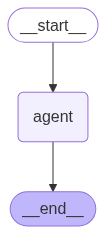

In [28]:
workflow_v2 = StateGraph(OverallState)

workflow_v2.add_node("agent", call_model_v2)

workflow_v2.add_edge(START, "agent")
workflow_v2.add_edge("agent", END)

graph_v2 = workflow_v2.compile()
graph_v2

In [29]:
config = {"configurable": {"language": "Spanish"}}
res1 = graph_v2.invoke({"question": "What is the capital of India"}, config=config)
res1

ValidationError: 1 validation error for OverallState
answer
  Field required [type=missing, input_value={'question': 'What is the capital of India'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [ ]:
config = {"configurable": {"language": "Spanish"}}
res1 = graph_v2.invoke({"question": "What is the capital of India"}, config=config)
res1